In [9]:
import numpy as np
import pandas as pd


# Set tables reading options
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

In [10]:
# Read the csv file
path = './data/'
file = 'HSL_crowd.csv'
df = pd.read_csv(path+file, sep=',', header=0)
df

,X,Y,OBJECTID,Nousijamaa,Nimi,Lyhyt_tunn
0,24.793840,60.195190,2001,47,Kivennapa,E2062
1,24.881440,60.153940,2002,23,Kiviaidankatu,H1054
2,24.903798,60.209607,2003,1,Kivihaankuja,H2111
3,24.903570,60.209397,2004,0,Kivihaankuja,H2110
4,24.903287,60.211553,2005,1,Kivihaantie,H2114
...,...,...,...,...,...,...
6703,25.084924,60.238799,3996,3,Ostoskuja,H4856
6704,25.086200,60.239470,3997,20,Ostostie,H4459
6705,25.086900,60.238460,3998,16,Ostostie,H4458
6706,24.933570,60.300780,3999,58,Osumakuja,V4139


# Clean the data

In [11]:
# Rename columns
to_rename={'X': 'stop_long',
           'Y': 'stop_lat',
           'OBJECTID': 'stop_id',
           'Nousijamaa': 'stop_passengers',
           'Nimi': 'stop_name',
           'Lyhyt_tunn': 'stop_code'
          }
df.rename(columns=to_rename, inplace=True)
df

,stop_long,stop_lat,stop_id,stop_passengers,stop_name,stop_code
0,24.793840,60.195190,2001,47,Kivennapa,E2062
1,24.881440,60.153940,2002,23,Kiviaidankatu,H1054
2,24.903798,60.209607,2003,1,Kivihaankuja,H2111
3,24.903570,60.209397,2004,0,Kivihaankuja,H2110
4,24.903287,60.211553,2005,1,Kivihaantie,H2114
...,...,...,...,...,...,...
6703,25.084924,60.238799,3996,3,Ostoskuja,H4856
6704,25.086200,60.239470,3997,20,Ostostie,H4459
6705,25.086900,60.238460,3998,16,Ostostie,H4458
6706,24.933570,60.300780,3999,58,Osumakuja,V4139


In [12]:
# Drop rows wihere long, lat et passengers are missing
#df = df.dropna()  # don't care about the names so don't drop rows if name is missing
df = df[(df['stop_long'].notnull()) & (df['stop_lat'].notnull()) & (df['stop_passengers'].notnull())]
df.reset_index(drop=True, inplace=True)
df

,stop_long,stop_lat,stop_id,stop_passengers,stop_name,stop_code
0,24.793840,60.195190,2001,47,Kivennapa,E2062
1,24.881440,60.153940,2002,23,Kiviaidankatu,H1054
2,24.903798,60.209607,2003,1,Kivihaankuja,H2111
3,24.903570,60.209397,2004,0,Kivihaankuja,H2110
4,24.903287,60.211553,2005,1,Kivihaantie,H2114
...,...,...,...,...,...,...
6703,25.084924,60.238799,3996,3,Ostoskuja,H4856
6704,25.086200,60.239470,3997,20,Ostostie,H4459
6705,25.086900,60.238460,3998,16,Ostostie,H4458
6706,24.933570,60.300780,3999,58,Osumakuja,V4139


# Reduce precision of lat and lon degrees
Source: https://en.wikipedia.org/wiki/Decimal_degrees

Scale for "neighborhood, street": 0.001 in decimal degrees.
Then, let's only keep the first three digits numbers.

In [13]:
df['stop_long'] = df['stop_long'].round(3) 
df['stop_lat'] = df['stop_lat'].round(3)
df

,stop_long,stop_lat,stop_id,stop_passengers,stop_name,stop_code
0,24.794,60.195,2001,47,Kivennapa,E2062
1,24.881,60.154,2002,23,Kiviaidankatu,H1054
2,24.904,60.210,2003,1,Kivihaankuja,H2111
3,24.904,60.209,2004,0,Kivihaankuja,H2110
4,24.903,60.212,2005,1,Kivihaantie,H2114
...,...,...,...,...,...,...
6703,25.085,60.239,3996,3,Ostoskuja,H4856
6704,25.086,60.239,3997,20,Ostostie,H4459
6705,25.087,60.238,3998,16,Ostostie,H4458
6706,24.934,60.301,3999,58,Osumakuja,V4139


# Convert GPS coordinates to spatial zones

## K-means
GPS cannot be used directly, as it is unlikely there is a true linear relationship. Hence, let's convert them into zones by using a clustering algorithm. The k-means algorithm is likely the most common clustering algorithm. Let's implement it.

/Users/antoinelouis/.local/share/virtualenvs/Junction-2019-fvZjpDfB/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


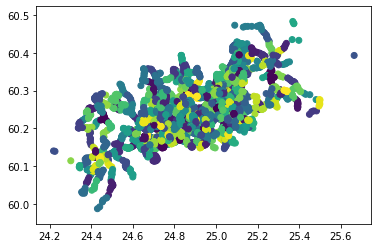

In [14]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import joblib

# Get coordinates
coordinates = df.as_matrix(columns=['stop_lat', 'stop_long'])

# Train the model
kmeans = KMeans(n_clusters=300, random_state=0).fit(coordinates)
labels = kmeans.labels_
centers = kmeans.cluster_centers_

# Save it and plot results
joblib.dump(kmeans, 'models/kmeans.pkl') 
plt.scatter(coordinates[:,1], coordinates[:,0], c=labels);
plt.show()

## DBSCAN
However, for spatial data, the DBSCAN algorithm is far superior. Indeed, the k-means algorithm groups N observations (i.e., rows in an array of coordinates) into k clusters. However, k-means is not an ideal algorithm for latitude-longitude spatial data because it minimizes variance, not geodetic distance. Instead, let’s use an algorithm that works better with arbitrary distances: scikit-learn’s implementation of the DBSCAN algorithm. DBSCAN clusters a spatial data set based on two parameters: a physical distance from each point, and a minimum cluster size. This method works much better for spatial latitude-longitude data.
Source: https://geoffboeing.com/2014/08/clustering-to-reduce-spatial-data-set-size/

In [15]:
from sklearn.cluster import DBSCAN
from geopy.distance import great_circle
from shapely.geometry import MultiPoint

# Get coordinates
coords = df.as_matrix(columns=['stop_lat', 'stop_long'])

# The epsilon parameter is the max distance that points can be from each other to be considered a cluster. 
kms_per_radian = 6371.0088
epsilon = 0.5 / kms_per_radian

# Create DBSCAN
db = DBSCAN(eps=epsilon, min_samples=1, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))

# Get the labels (list) and their numbers
cluster_labels = db.labels_
num_clusters = len(set(cluster_labels))
print('Number of clusters: {}'.format(num_clusters))

# Get the clusters with their data points
clusters = pd.Series([coords[cluster_labels == n] for n in range(num_clusters)])

# Add a column for the cluster label
df['cluster'] = cluster_labels
df


/Users/antoinelouis/.local/share/virtualenvs/Junction-2019-fvZjpDfB/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Number of clusters: 321


,stop_long,stop_lat,stop_id,stop_passengers,stop_name,stop_code,cluster
0,24.794,60.195,2001,47,Kivennapa,E2062,0
1,24.881,60.154,2002,23,Kiviaidankatu,H1054,1
2,24.904,60.210,2003,1,Kivihaankuja,H2111,0
3,24.904,60.209,2004,0,Kivihaankuja,H2110,0
4,24.903,60.212,2005,1,Kivihaantie,H2114,0
...,...,...,...,...,...,...,...
6703,25.085,60.239,3996,3,Ostoskuja,H4856,0
6704,25.086,60.239,3997,20,Ostostie,H4459,0
6705,25.087,60.238,3998,16,Ostostie,H4458,0
6706,24.934,60.301,3999,58,Osumakuja,V4139,0


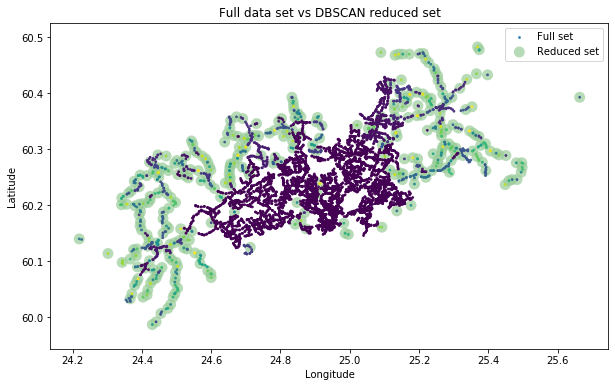

In [16]:
import matplotlib.pyplot as plt


def get_centermost_point(cluster):
    """
    Returns the cluster's center-most point
    """
    centroid = (MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y)
    centermost_point = min(cluster, key=lambda point: great_circle(point, centroid).m)
    return tuple(centermost_point)


# Get all center-most points for all clusters
centermost_points = clusters.map(get_centermost_point)


# Visualize full dataset compared to clustered one
lats, lons = zip(*centermost_points)
rep_points = pd.DataFrame({'stop_long':lons, 'stop_lat':lats})
rs = rep_points.apply(lambda row: df[(df['stop_lat']==row['stop_lat']) & (df['stop_long']==row['stop_long'])].iloc[0], axis=1)

fig, ax = plt.subplots(figsize=[10, 6])
rs_scatter = ax.scatter(rs['stop_long'], rs['stop_lat'], c='#99cc99', edgecolor='None', alpha=0.7, s=120)
df_scatter = ax.scatter(df['stop_long'], df['stop_lat'], c=cluster_labels, alpha=0.9, s=3)
ax.set_title('Full data set vs DBSCAN reduced set')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend([df_scatter, rs_scatter], ['Full set', 'Reduced set'], loc='upper right')
plt.show()

# Discretize outputs

In [17]:
# Check percentiles
outputs = np.array(df['stop_passengers'])
percentiles = [25,50,75]
res = [np.percentile(outputs, i) for i in percentiles]
print(res)

[3.0, 21.0, 109.0]


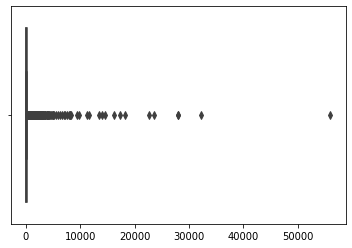

In [18]:
import seaborn as sns

# Check outliers
sns.boxplot(x=outputs)

Hence, let's divide the number of passengers in 4 classes:
    1. 'not_crowded' : between 0-3 people (first percentile)
    2. 'usual': between 3-21 people (second percentile)
    3. 'crowded': between 21-109 people (third percentile)
    4. 'very_crowded': more than 109 people (last percentile)

In [19]:
def label_crowd(row):
    if row['stop_passengers'] <= 3:
      return 'not_crowded'
    if row['stop_passengers'] > 3 and row['stop_passengers'] <= 21:
      return 'usual'
    if row['stop_passengers'] > 21 and row['stop_passengers'] <= 109:
      return 'crowded'
    if row['stop_passengers'] > 109:
      return 'very_crowded'
    return 'other'


df['crowd_class'] = df.apply(lambda row: label_crowd(row), axis=1)
df

,stop_long,stop_lat,stop_id,stop_passengers,stop_name,stop_code,cluster,crowd_class
0,24.794,60.195,2001,47,Kivennapa,E2062,0,crowded
1,24.881,60.154,2002,23,Kiviaidankatu,H1054,1,crowded
2,24.904,60.210,2003,1,Kivihaankuja,H2111,0,not_crowded
3,24.904,60.209,2004,0,Kivihaankuja,H2110,0,not_crowded
4,24.903,60.212,2005,1,Kivihaantie,H2114,0,not_crowded
...,...,...,...,...,...,...,...,...
6703,25.085,60.239,3996,3,Ostoskuja,H4856,0,not_crowded
6704,25.086,60.239,3997,20,Ostostie,H4459,0,usual
6705,25.087,60.238,3998,16,Ostostie,H4458,0,usual
6706,24.934,60.301,3999,58,Osumakuja,V4139,0,crowded


# Save data

In [20]:
new_file = 'cleaned_HSL_data.csv'
df.to_csv(path+new_file, sep=',', encoding='utf-8', float_format='%.3f', decimal='.')